## Goal: 
Search for anomaly with unsupervised learning (no labeled data).

## Methods:
**point anomalies:** Gaussian (elliptic envelope)  

In [201]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np
import operator

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# 1 Data
## 1.1 Extract data


In [2]:
node_traffic_duration = pd.read_excel('DurationAndPayloadByMarketAndNodeAndProtocol.xlsx',sheet_name=0, header=1,skip_rows=1,usecols='A:G')

## 1.2 Understand data

##### Condition for filtering the data
filter all the data where ratio is NaN
filter all the data that has ratio 100% and describe those 1.5*(IQR)

In [3]:
df = node_traffic_duration[pd.notnull(node_traffic_duration['RATIO(%)'])]

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571667 entries, 0 to 572417
Data columns (total 7 columns):
DAY                 571667 non-null datetime64[ns]
MARKET              571667 non-null object
NODE                571667 non-null object
PROTOCOL            568721 non-null object
NON-LTE_SUM         571667 non-null float64
ALL_RAT_TYPE_SUM    571667 non-null float64
RATIO(%)            571667 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 34.9+ MB
None


<IPython.core.display.Javascript object>


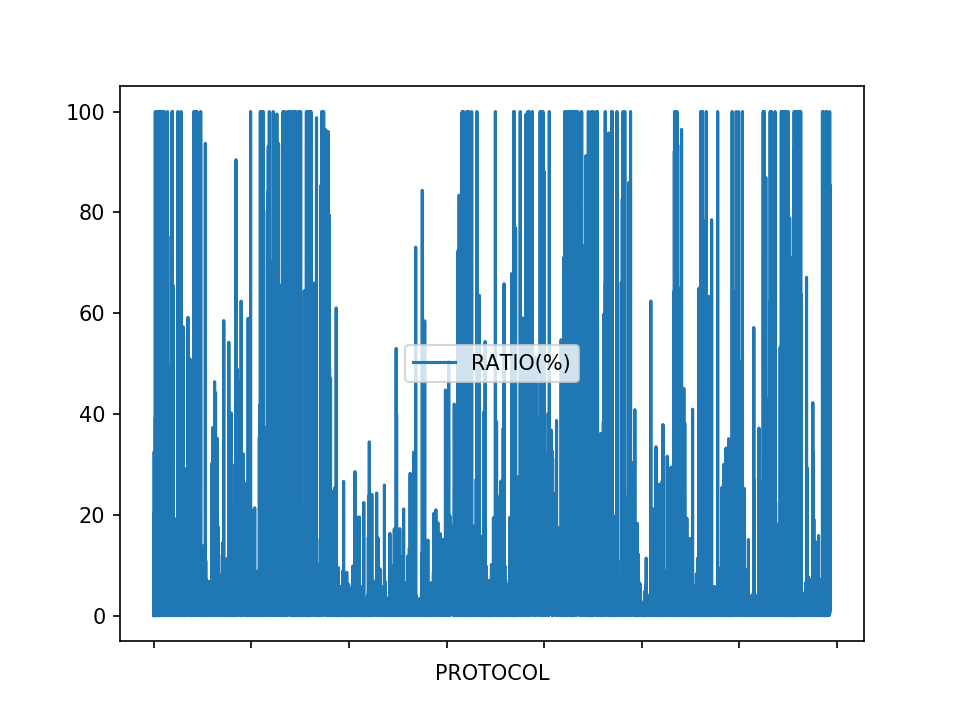

In [5]:
df[df['DAY']=='2018-08-01'].plot(x='PROTOCOL', y='RATIO(%)')

## 1.3 Feature engineering
Extracting some useful features

In [6]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['DAY'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

c:\users\arunkumarrn\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\arunkumarrn\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
markets = df['MARKET'].unique()

In [8]:
markets

array(['LONG ISLAND', 'LOS ANGELES', 'SEATTLE', 'SOUTH CAROLINA'],
      dtype=object)


# 2 Models

## 2.1 Categories + Gaussian
#### Use for contextual data and collective anomalies (unordered).  
We will separate data by markets. Then we find outliers (gaussian repartition, unimodal) by categories independently.   

In [9]:
li_df, la_df, se_df, sc_df = [df[df['MARKET']==market] for market in markets]

<IPython.core.display.Javascript object>


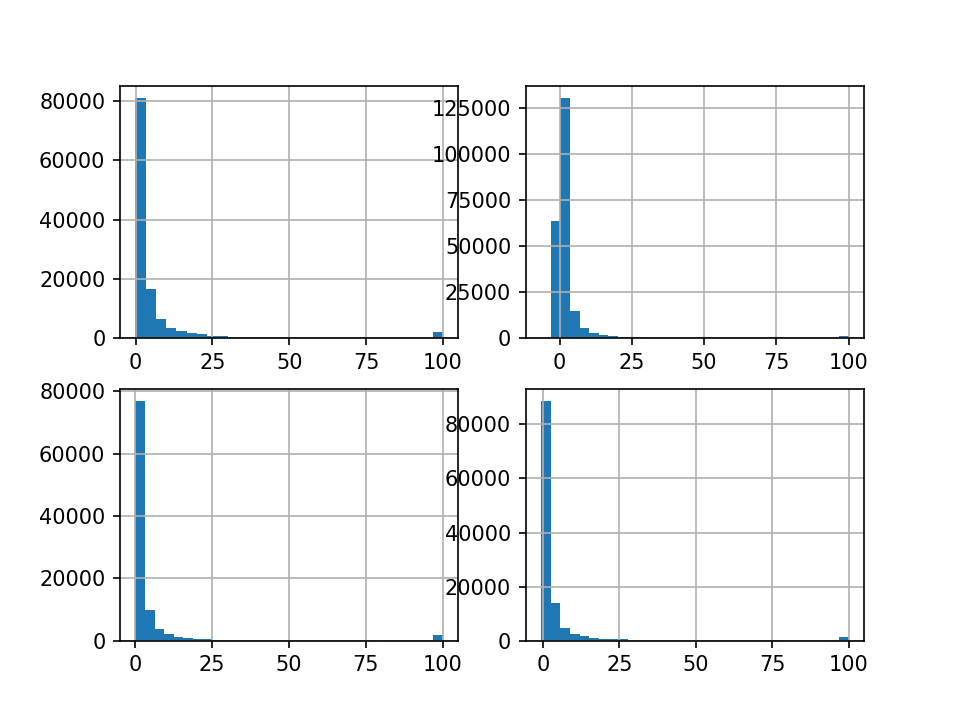

In [10]:
# plot the leakage ratio by categories
fig, axs = plt.subplots(2,2)
li_df['RATIO(%)'].hist(ax=axs[0,0],bins=30)
la_df['RATIO(%)'].hist(ax=axs[0,1],bins=32)
se_df['RATIO(%)'].hist(ax=axs[1,0],bins=32)
sc_df['RATIO(%)'].hist(ax=axs[1,1],bins=32)

In [163]:
li_y = li_df['NON-LTE_SUM']**0.2
la_y = la_df['NON-LTE_SUM']**0.2
se_y = se_df['NON-LTE_SUM']**0.2
sc_y = sc_df['NON-LTE_SUM']**0.2

<IPython.core.display.Javascript object>


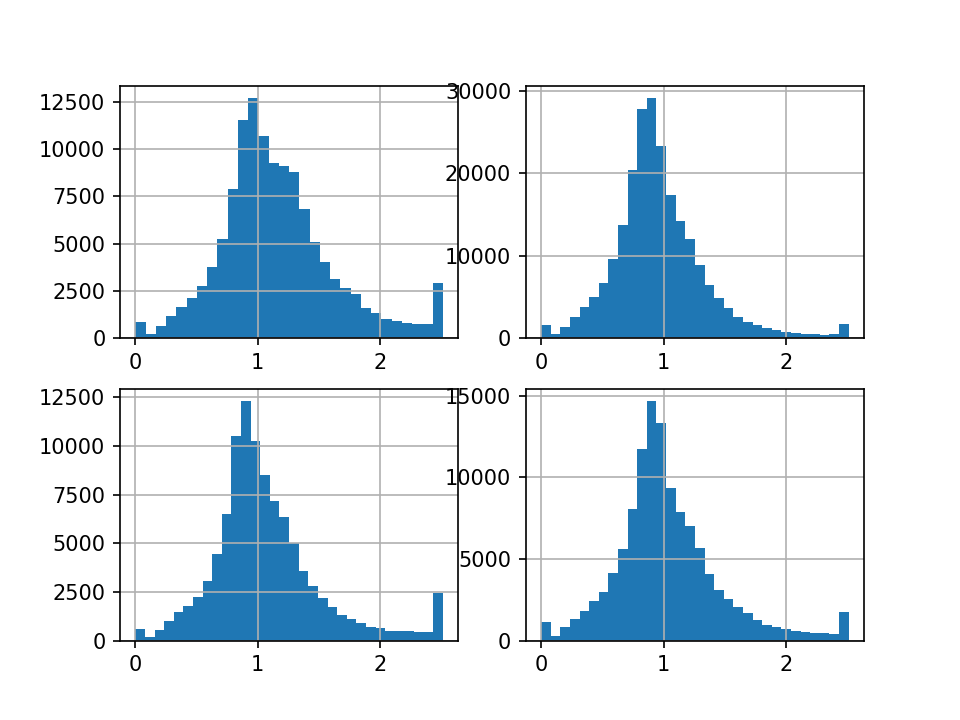

In [164]:
# plot the leakage ratio by categories
fig, axs = plt.subplots(2,2)
li_x.hist(ax=axs[0,0],bins=30)
la_x.hist(ax=axs[0,1],bins=32)
se_x.hist(ax=axs[1,0],bins=32)
sc_x.hist(ax=axs[1,1],bins=32)

In [11]:
li_x = li_df['RATIO(%)']**0.2
la_x = la_df['RATIO(%)']**0.2
se_x = se_df['RATIO(%)']**0.2
sc_x = sc_df['RATIO(%)']**0.2

<IPython.core.display.Javascript object>


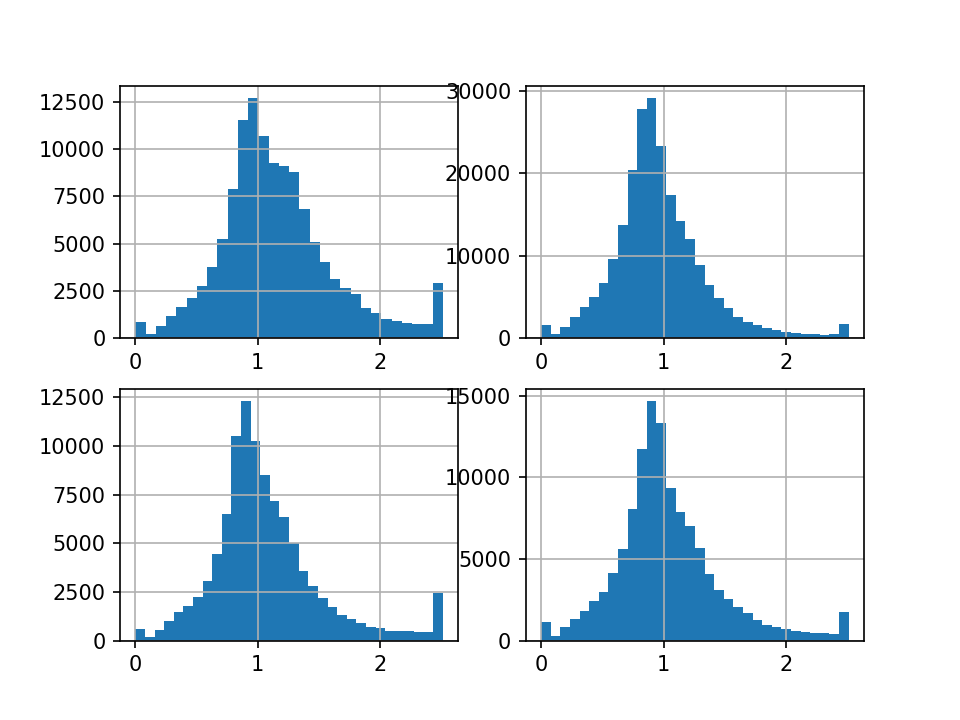

In [12]:
# plot the leakage ratio by categories
fig, axs = plt.subplots(2,2)
li_x.hist(ax=axs[0,0],bins=30)
la_x.hist(ax=axs[0,1],bins=32)
se_x.hist(ax=axs[1,0],bins=32)
sc_x.hist(ax=axs[1,1],bins=32)

All the market segments has few cases with Non-LTE to All RAT ratio at 100%

#### For each market, A quantile condition, depending on which the evaluation happens
> What's the methodology to find a quantile condition? Currently, it is above 95th quantile


1. Ratio of New data point is greater than the severe leakage quantile, check if it falls above the 95th quantile of NON-LTE_SUM, then filter for each day and sort on NON-LTE descending and ALL RAT ascending and rank the anomaly

*This method considers eliminates the smaller value, as the initial quantile condition is applied based on the entire NON-LTE distribution from the market* 
*The above won't happen in Gaussian, because it is modelled for the entire distribution

2. If it's less, run gaussian distribution and get the list of anomalies, with their abs(deviations)
3. Run gaussian on the NON-LTE duration and get the list of anomalies, with their abs(deviations)
4. Run dot product of these two, based on the product, assign rank.
5. Evaluate the results and get feedback and validate this methodology
 
 Next Step: we can use this as a supervised examples for a classification problem
        Transform the RATIO(%) to RATIO(%)**0.2 and see if that helps for the gaussian analysis
        Consider entity embeddings of protocol against anomaly and use it in logistic regression, a baseline approach
        
> **Question**: Suppose an example where NON-LTE duration is in 100k secs and it's LTE is 900ksecs, is this an anomaly?<br/>
> **Answer**: This won't be caught as an anomaly in the first rule, also won't be caught by Gaussian as the RATIO is 10%. But, with the third and fourth rule, gaussian on NON-LTE will give higher deviation from it's modelled distribution and the product will give higer rank

**Checks**: <br/>
| NOTE: Understand how this will shown in different levels| Answered or not?

#### FIRST STEP

In [171]:
li_df['new_ratio'], la_df['new_ratio'], se_df['new_ratio'],sc_df['new_ratio'] = li_x, la_x, se_x, sc_x

c:\users\arunkumarrn\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [172]:
def iqr(test):
    y = test.quantile(0.75) + 2*(test.quantile(0.75) - test.quantile(0.25))
    return y

In [160]:
li_qu, la_qu, se_qu, sc_qu = [iqr(i) for i in [li_df['new_ratio'], la_df['new_ratio'], se_df['new_ratio'],sc_df['new_ratio']]]
li_lte_qu, la_lte_qu, se_lte_qu, sc_lte_qu = [iqr(i) for i in [li_df['NON-LTE_SUM']**0.2, la_df['NON-LTE_SUM']**0.2, se_df['NON-LTE_SUM']**0.2,sc_df['NON-LTE_SUM']**0.2]]

In [183]:
QUANTILE_RATIO = 0.9 #This quantile will change for each of the market
NON_LTE_RATIO = 0.98 #This non-lte-ratio will change for each of the market, this is what gaussian is doing. 
                    # We need to have these two variables, each of the markets

In [184]:
df_ls = [li_df, la_df, se_df, sc_df]
li_gt_95, la_gt_95, se_gt_95, sc_gt_95 = [df[df['new_ratio'] > quan] for df, quan in zip(df_ls, [li_qu, la_qu, se_qu, sc_qu])]

In [185]:
li_non_lte_filtered, la_non_lte_filtered, se_non_lte_filtered, sc_non_lte_filtered = [df[df['NON-LTE_SUM']>(df['NON-LTE_SUM'].quantile(NON_LTE_RATIO))].reset_index(drop=True) for df in [li_gt_95, la_gt_95, se_gt_95, sc_gt_95]]
li_non_lte_filtered['RN'], la_non_lte_filtered['RN'], se_non_lte_filtered['RN'], sc_non_lte_filtered['RN'] = [anomalies_in_first_filter.sort_values(['NON-LTE_SUM', 'ALL_RAT_TYPE_SUM'], ascending=[False, True]).groupby(['DAY']).cumcount()+1 for anomalies_in_first_filter in [li_non_lte_filtered, la_non_lte_filtered, se_non_lte_filtered, sc_non_lte_filtered]] 

In [186]:
li_non_lte_filtered[li_non_lte_filtered['DAY']=='2018-08-01'].sort_values('RN')

,DAY,MARKET,NODE,PROTOCOL,NON-LTE_SUM,ALL_RAT_TYPE_SUM,RATIO(%),DayOfTheWeek,WeekDay,new_ratio,RN
3,2018-08-01,LONG ISLAND,PHPCF000,dns,1153575.000,1419713.313,81.254081,2,1,2.409734,1
2,2018-08-01,LONG ISLAND,NYPGW112,talkatone,85479.277,85479.277,100.000000,2,1,2.511886,2
0,2018-08-01,LONG ISLAND,DCPCF001,soundcloud,47632.202,47633.022,99.998279,2,1,2.511878,3
1,2018-08-01,LONG ISLAND,NYPCF014,flash,37940.355,41943.401,90.456077,2,1,2.461997,4


##### SECOND STEP

In [187]:
df_filtered_ls = [li_gt_95, la_gt_95, se_gt_95, sc_gt_95]
li_rest, la_rest, se_rest, sc_rest = [df[df['new_ratio']<=quan].reset_index(drop=True) for df, quan in zip(df_ls, [li_qu, la_qu, se_qu, sc_qu])]
li_rest_x, la_rest_x, se_rest_x, sc_rest_x = [i['RATIO(%)']**0.2 for i in [li_rest, la_rest, se_rest, sc_rest]]

<IPython.core.display.Javascript object>


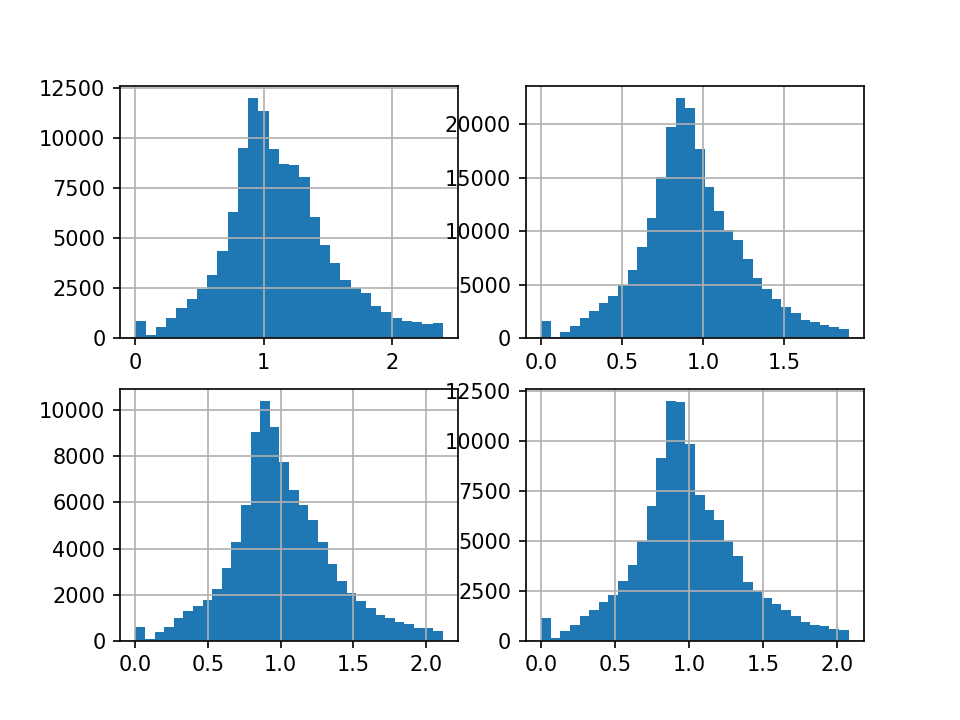

In [188]:
# plot the leakage ratio by categories
fig, axs = plt.subplots(2,2)
li_rest_x.hist(ax=axs[0,0],bins=30)
la_rest_x.hist(ax=axs[0,1],bins=32)
se_rest_x.hist(ax=axs[1,0],bins=32)
sc_rest_x.hist(ax=axs[1,1],bins=32)

###### Entity Embeddings with Protocols

Check this from FastAi

In [189]:
def predict_anomaly(df_class0):
    envelope =  EllipticEnvelope(contamination = outliers_fraction) 
    X_train = df_class0.values.reshape(-1,1)
    envelope.fit(X_train)
    df_class0 = pd.DataFrame(df_class0)
    df_class0['deviation'] = envelope.decision_function(X_train)
    df_class0['anomaly'] = envelope.predict(X_train)
    return df_class0

In [190]:
li_pred, la_pred, se_pred, sc_pred = [predict_anomaly(i['new_ratio']) for i in [li_rest, la_rest, se_rest, sc_rest]]
#li_non_pred, la_non_pred, se_non_pred, sc_non_pred = [predict_anomaly(i['NON-LTE_SUM']) for i in [li_rest, la_rest, se_rest, sc_rest]]

In [197]:
test = li_rest['new']

,DAY,MARKET,NODE,PROTOCOL,NON-LTE_SUM,ALL_RAT_TYPE_SUM,RATIO(%),DayOfTheWeek,WeekDay,new_ratio
0,2018-08-01,LONG ISLAND,ATPCF003,dns,1.033,32757.240,0.003154,2,1,0.316052
1,2018-08-01,LONG ISLAND,ATPCF003,facebook,541.823,32610.594,1.661494,2,1,1.106878
2,2018-08-01,LONG ISLAND,ATPCF003,google,275.810,166010.554,0.166140,2,1,0.698385
3,2018-08-01,LONG ISLAND,ATPCF003,http,123.289,6974.186,1.767791,2,1,1.120692
4,2018-08-01,LONG ISLAND,ATPCF003,ssl,1.150,92909.692,0.001238,2,1,0.262136


In [199]:
check = test['new_ratio'].values.reshape(-1,1)

In [193]:
envelope_li =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = li_rest['new_ratio'].values.reshape(-1,1)
envelope_li.fit(X_train)

envelope_la =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = la_rest['new_ratio'].values.reshape(-1,1)
envelope_la.fit(X_train)

envelope_se =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = se_rest['new_ratio'].values.reshape(-1,1)
envelope_se.fit(X_train)

envelope_sc =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = sc_rest['new_ratio'].values.reshape(-1,1)
envelope_sc.fit(X_train)

EllipticEnvelope(assume_centered=False, contamination=0.01, random_state=None,
         store_precision=True, support_fraction=None)

In [200]:
envelope_li.predict(check)

array([1, 1, 1, 1, 1])

In [50]:
#li_pred['gauss_deviation'], la_pred['gauss_deviation'], se_pred['gauss_deviation'], sc_pred['gauss_deviation'] = [list(map(operator.mul, abs(pred['deviation']), abs(non_pred['deviation']))) for pred, non_pred in zip([li_pred, la_pred, se_pred, sc_pred],[li_non_pred, la_non_pred, se_non_pred, sc_non_pred]) ]

##### This is all at MARKET DAY LEVEL ranking

In [76]:
def concat_and_rank(rest, pred):
    temp_df = pd.concat([rest,pred.drop('RATIO(%)', axis=1).reset_index(drop=True)], axis=1)
    temp_df['RNK'] = temp_df.groupby(['DAY', 'anomaly'])['NON-LTE_SUM'].rank(ascending=False)
    temp_df = temp_df[temp_df['anomaly']==-1].sort_values('RNK', ascending=True).reset_index(drop=True)
    return temp_df

In [77]:
li, la, se, sc =[concat_and_rank(rest, pred) for rest, pred in zip([li_rest, la_rest, se_rest, sc_rest], [li_pred, la_pred, se_pred, sc_pred])]

In [170]:
li.sort_values('RNK')

,DAY,MARKET,NODE,PROTOCOL,NON-LTE_SUM,ALL_RAT_TYPE_SUM,RATIO(%),DayOfTheWeek,WeekDay,deviation,anomaly,gauss_deviation,RNK
0,2018-08-05,LONG ISLAND,NYPCF000,dns,774817.199,989888.181,78.273204,6,0,-1416.405304,-1,2.376530e+10,1.0
30,2018-08-26,LONG ISLAND,PHPCF000,dns,578095.243,802520.306,72.034968,6,0,-99.035153,-1,1.677124e+09,1.0
29,2018-08-23,LONG ISLAND,PHPCF000,dns,729989.099,951902.890,76.687350,3,1,-1071.011138,-1,1.801243e+10,1.0
28,2018-08-11,LONG ISLAND,PHPCF000,dns,622569.273,838715.334,74.228913,5,0,-549.719270,-1,9.292088e+09,1.0
27,2018-08-10,LONG ISLAND,NEPCF000,dns,634218.806,855598.118,74.125783,4,1,-528.227398,-1,8.924270e+09,1.0
26,2018-08-30,LONG ISLAND,NYPCF000,dns,717311.496,951607.842,75.378897,3,1,-791.423100,-1,1.331879e+10,1.0
25,2018-08-09,LONG ISLAND,DCPCF001,dns,583130.985,752727.288,77.469091,3,1,-1240.377358,-1,2.100108e+10,1.0
24,2018-08-31,LONG ISLAND,NEPCF000,dns,765727.521,1050250.570,72.909032,4,1,-276.945330,-1,4.649028e+09,1.0
23,2018-08-24,LONG ISLAND,NYPCF000,dns,724956.523,976302.305,74.255333,4,1,-555.229952,-1,9.340326e+09,1.0
21,2018-08-03,LONG ISLAND,NEPCF000,dns,882872.055,1146109.715,77.032071,4,1,-1145.481634,-1,1.909925e+10,1.0


<IPython.core.display.Javascript object>


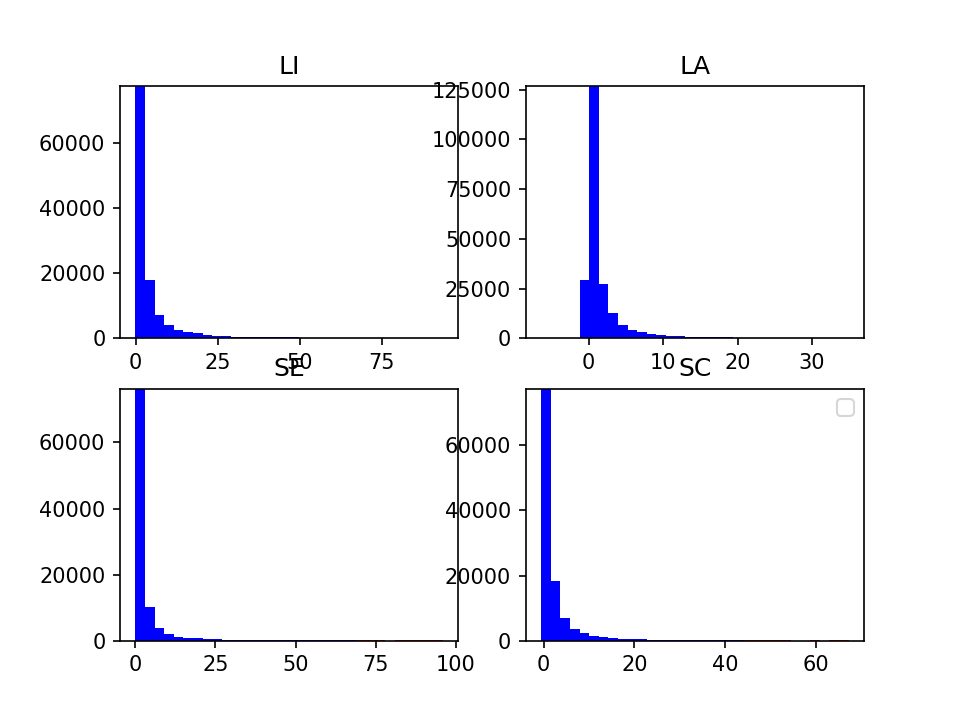

No handles with labels found to put in legend.


In [83]:
a0 = li_pred.loc[li_pred['anomaly'] == 1, 'RATIO(%)']
b0 = li_pred.loc[li_pred['anomaly'] == -1, 'RATIO(%)']

a1 = la_pred.loc[la_pred['anomaly'] == 1, 'RATIO(%)']
b1 = la_pred.loc[la_pred['anomaly'] == -1, 'RATIO(%)']

a2 = se_pred.loc[se_pred['anomaly'] == 1, 'RATIO(%)']
b2 = se_pred.loc[se_pred['anomaly'] == -1, 'RATIO(%)']

a3 = sc_pred.loc[sc_pred['anomaly'] == 1, 'RATIO(%)']
b3 = sc_pred.loc[sc_pred['anomaly'] == -1, 'RATIO(%)']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'])
axs[0,0].set_title("LI")
axs[0,1].set_title("LA")
axs[1,0].set_title("SE")
axs[1,1].set_title("SC")
plt.legend()
plt.show()

In [198]:
# add the data to the main 
df_class = pd.concat([li_pred, la_pred, se_pred, sc_pred])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

c:\users\arunkumarrn\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\arunkumarrn\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


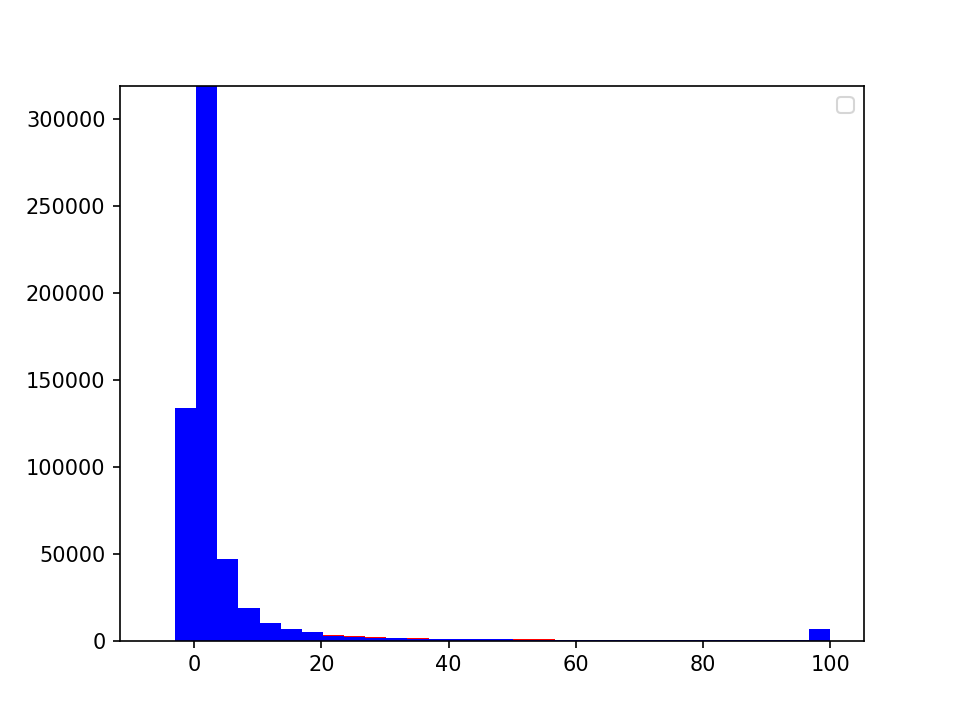

No handles with labels found to put in legend.


In [200]:
a = df.loc[df['anomaly22'] == 0, 'RATIO(%)']
b = df.loc[df['anomaly22'] == 1, 'RATIO(%)']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

Good detections of extreme values and context separation add some precision to the detection.

## 2.5 Isolation Forest
#### Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [30]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


In [31]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>


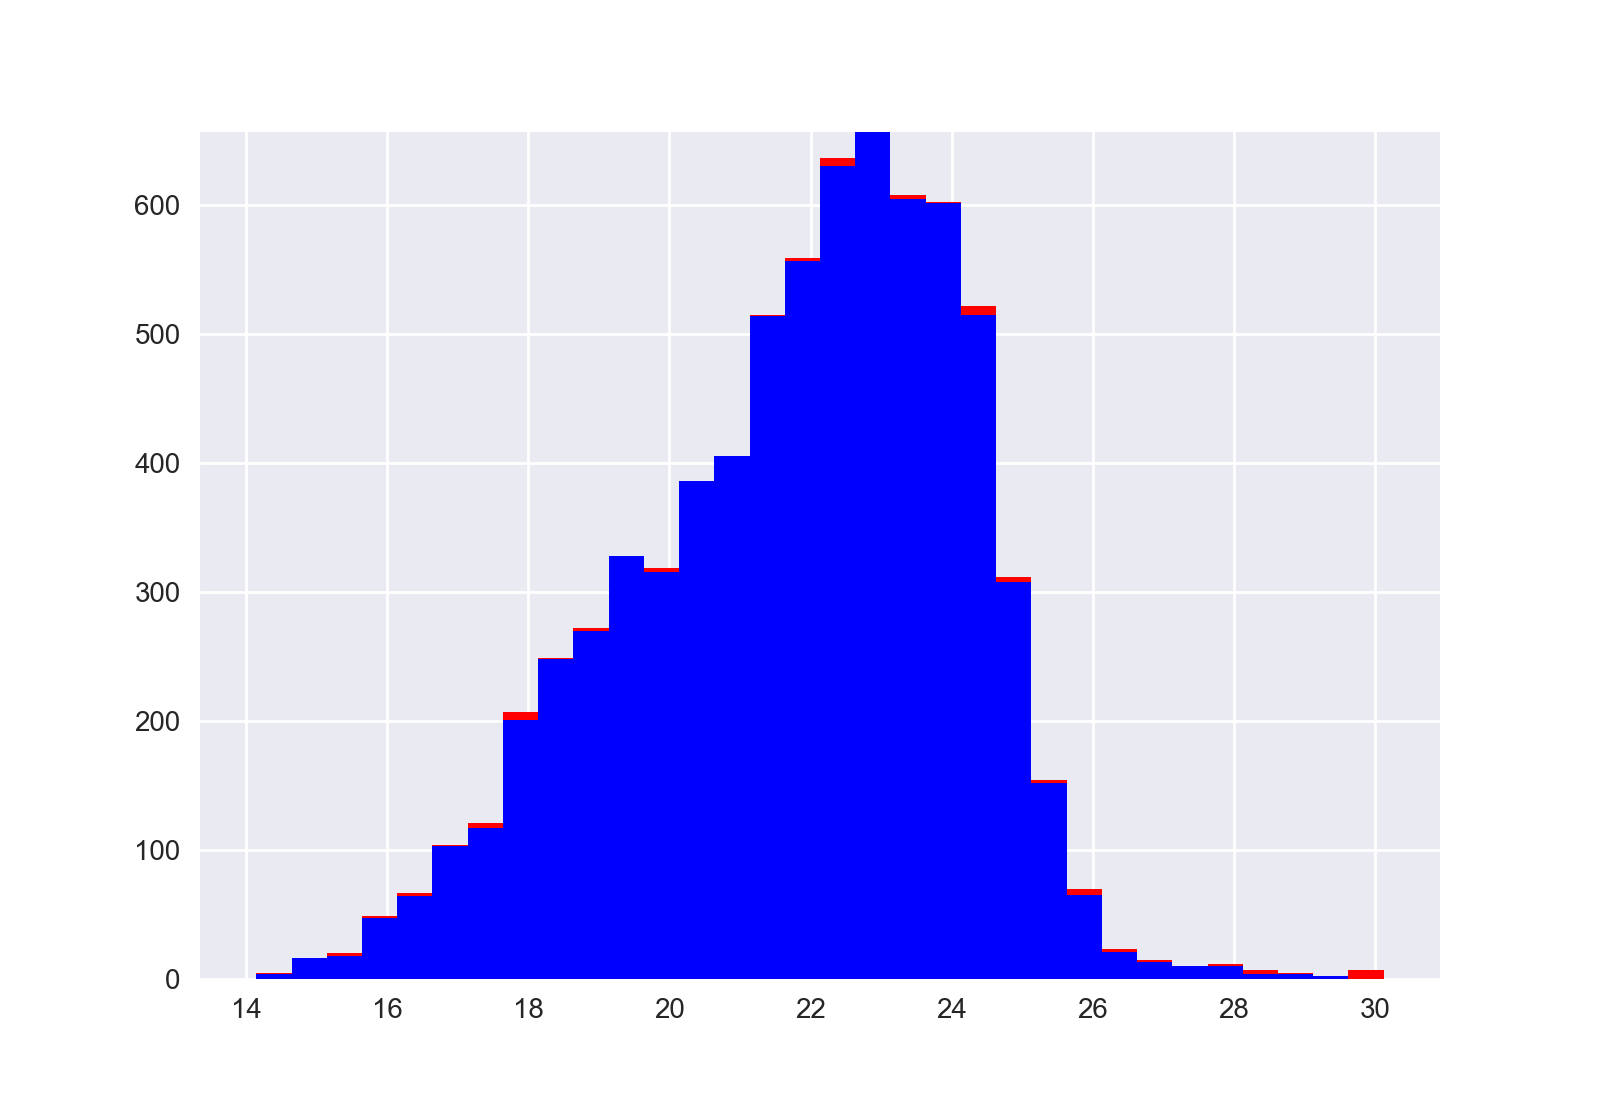

In [32]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.
## 2.7 RNN
#### Use for  sequential anomalies (ordered)
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.  
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [65]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

In [66]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

('x_train', (6165, 50, 5))
('y_train', (6165,))
('x_test', (1000, 50, 5))
('y_test', (1000,))


In [67]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries
from keras.models import model_from_json

Using TensorFlow backend.


In [68]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.0335388183594


## 3 Result comparison

## 4 Conclusion
For this case, the contextual anomaly detection (categories+elliptique enveloppe) seem a good solution. 